# Project Definition

 ### <a class="anchor" id="Project-Overview">Part I : Project-Overview</a>
 
In this project we have Data that mimic's the behavior of the Starbucks clients when using the app for purchasing one product and his transactions. Also, this Data contains a series of offers that Starbucks send to their clients. The problem domain is centered in giving offers to people in a random way that could be inefficient because some people won´t react to the offer or in some other cases people consume with high frequency so if we decide to give them an offer, that could be not beneficial for the based earnings of Starbucks.

The main purpose or origin of this project consists on understanding the reaction of the clients based on the offers had been sent to them, with the goal of finding a better way to optimize who Starbucks will send their offers for getting the maximum revenue to the company.

This project is part of the DataScientist Nanodegree program from Udacity.

Data Sets: The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record
 
 ### <a class="anchor" id="Project Statement">Part II :Project Statement</a>

For achieving the porpuse of the project, we will want to answer the following question:

Based on the demographics like: age, time since member, income, gender; find a model that better predict wether the client will response positively to the offer send by starbucks.

For doing that, we will make a series of cleaning steps over the data. At the end of the day, we would like to have a matrix where we have the characteristics of the population that the APP has, if at any point in the sample it received one of the different types of offer and finally if the consumer decided to complete it.

With this matrix we will be able to run Machine Learning models to identify the demographic characteristics that define whether or not the user will use the offer sent by starbucks, in order to finally see the effectiveness of the model and be able to forecast given the characteristics of the user and his propensity for purchasing the product.

This will imply checking if we will use a different machine learning model for each of the offers or if in any case we implement a single model that tries to explain all the offers.


  ### <a class="anchor" id="Metrics">Part III :Metrics</a>
 
The metrics that we will use are statistics over the results of the model like precision, recall and F1-score. These metrics are the best suited to the problem because they attempt to review the effectiveness of machine learning models.

In the sklearn library, we found the following definitions.

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import preprocessing


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Analysis

### <a class="anchor" id="Data-Exploration">Part I : Data-Exploration</a>

Here we calculated some statistics and Features relevants to the problem for each of the input data.

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
# Find and explore number of null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:

profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In the profile data we have missing values in terms of gender and income. It seems that are the same persons at a first glance.

In [7]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [8]:
# Describe each df
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


The portfolio matrix shows the difficulty of the offers, where 0 are the offers that are informational since they do not require a minimum amount to be used. Instead there are difficulties between 5 and 20 that can influence consumer behavior.

Regarding the duration, we see that the minimum and maximum is between 3 and 10. And regarding the reward, it is also observed that the minimum is 0 for the informational ones and reaches a maximum of 10, which according to the portfolio are those BOGO offers.


In [9]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


The age variable has a mean of 62 years, which is high versus the population standard. Reviewing the head of the profile, we find that those with null are those that has age 118 in the data, which gives us signals that these information cannot be used. The "became_member_on" variable shows the date they entered the app and is in yyyymmdd format. Finally, the variable income, which has a minimum of 30,000 and a maximum of 120,000, which for the income ranges of society could be much higher.

In [10]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [11]:
# Checking how many events has the transcript variable
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

### <a class="anchor" id="Data-Visualization">Part II : Data-Visualization</a>

Here we calculated some visualizations for each of the input data.

Text(0,0.5,'Number of customers')

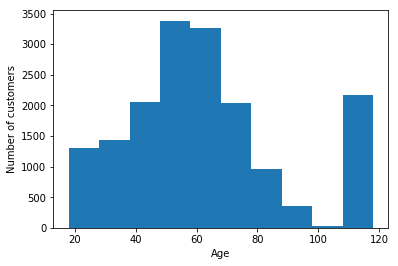

In [12]:
#Age Distribution
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Number of customers')


The age distribution shows again the last percentile which is inconsistent with a normal distribution, where a high percentage of the sample is close to the value of 118. I should review in the next sections to define what treatment will need this data.

Text(0,0.5,'Number of customers')

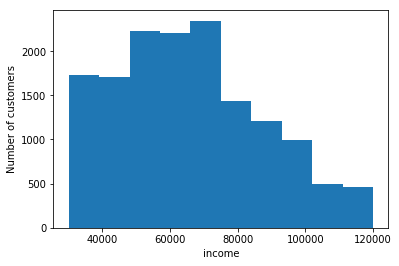

In [13]:
#Income distribution
profile_nonan=profile.dropna(axis=0)
plt.hist(profile_nonan['income'])
plt.xlabel('income')
plt.ylabel('Number of customers')


The income distribution shows that the highest concentration of data is centered around 60-70 thousand, and begins to have less frequency from 80 thousand.

Text(0.5,1,'Event Types')

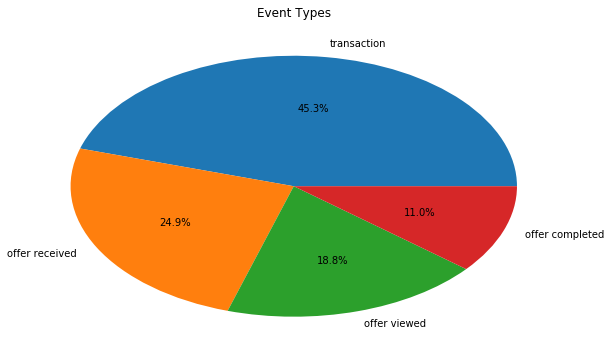

In [14]:
transcript['event'].value_counts(normalize=True).plot.pie(figsize=(10,6), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Event Types')

Finally, we can see that in transcript data we identify that 45% of the rows correspond to transactions made in the app by customers. The next highest percent are offers received, representing 24.9% and offers viewed are 18.8%. Here it shows the need in the following steps to focus on the users who receive the offer because if they did not see it, it is a fact that they will not be influenced by it. Finally, another key variable is the completed offer that represents 11%of the total, which becomes relevant for BOGOs and discounts offers

# Methodology


### <a class="anchor" id="Data-Exploration">Part I : Data-Preprocessing</a>

For this section we will list the steps that must be followed in order to transform the information and make it ready for the Machine Learning model.

Merging the 3 df for having the complete information by transactions, clients and types of offers.

* Merge transcript and profile based on id
* Fix null values of this new base.
* Transform the value variable for getting the amount id for transaction and the offer id for offers and assign new variables. Drop the value column


In [15]:
dftranscript_profile=transcript.merge(profile,left_on='person',right_on='id')

In [16]:
dftranscript_profile.describe()

,time,age,became_member_on,income
count,306534.000000,306534.000000,3.065340e+05,272762.000000
mean,366.382940,60.909367,2.016545e+07,64337.000755
std,200.326314,26.032030,1.190460e+04,21243.762941
min,0.000000,18.000000,2.013073e+07,30000.000000
25%,186.000000,43.000000,2.016032e+07,48000.000000
50%,408.000000,57.000000,2.017041e+07,62000.000000
75%,528.000000,72.000000,2.017113e+07,78000.000000
max,714.000000,118.000000,2.018073e+07,120000.000000


In [17]:
dftranscript_profile.isnull().sum()

event                   0
person                  0
time                    0
value                   0
age                     0
became_member_on        0
gender              33772
id                      0
income              33772
dtype: int64

In [18]:
# Explore how many missing values are when merging both variables
dftranscript_profile_temporal=dftranscript_profile.drop_duplicates(subset='id')

In [19]:
#Proportion of profiles that are null vs all the profiles
dftranscript_profile_temporal[dftranscript_profile_temporal.gender.isnull()].id.isin(profile.id.values.tolist()).sum()/profile.id.values.shape[0]


0.12794117647058822

I decided to exclude this data from the DF, given the following reasons:

1. Number of nulls of the profile variable, just 2175 over 17000 profiles (12.8%)
2. The nulls profiles also has an age of 118, which is set by default.
3. The only variable that could be used for this data is "became_member_on". Nevertheless, just this characteristic is not useful for a machine learning model and imputation will not correct this problem.



In [20]:
dftranscript_profile=dftranscript_profile[dftranscript_profile.gender.isnull()==False]
profile=profile[profile.income.isnull()==False]

In [21]:
dftranscript_profile

,event,person,time,value,age,became_member_on,gender,id,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
3,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
6,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0


In [22]:
# Transform the data
values_df=pd.DataFrame(dftranscript_profile.value.values.tolist())

In [23]:
# for the transactions having col name offer id and offers having offer id, I decide to just mantain one named "offers"
values_df['offers']=values_df['offer_id'].combine_first(values_df['offer id'])

In [24]:
# Drop the columns duplicate
values_df=values_df.drop(['offer id','offer_id'],axis=1)

In [25]:
dftranscript_profile['amount']=values_df.amount.values.tolist()
dftranscript_profile['reward']=values_df.reward.values.tolist()
dftranscript_profile['offers']=values_df.offers.values.tolist()

In [26]:
dftranscript_profile_portfolio=dftranscript_profile.merge(portfolio,left_on='offers',right_on='id',how='left')

### Tables for Not Informational and Informational Offers

Separate the offers into two groups.

(1) Non informational offers


* Filter by discounts and BOGO offers and generate a table (id in index and offer in columns) for both viewed and completed offers (we exclude those received because they do not generate value to answer the question asked).
* In some cases, a user can view more than one offer of the same type or complete a greater number of offers than he had seen. In that sense. A standardization is carried out to identify if a user was indeed influenced by the offer. For this, we divide the table of offers seen in itself to standardize to 1 (saw the offer or not). Later we divide the completed table against the table seen (element-wise, important that we must homologate both tables since they have different number of id's). With this, we define a function for each element such that:
 
 a. If it´s greater than 1 (more completed offers than viewed), then it is because the user completed an offer that he never saw, therefore he was not influenced by it. We care about the cases in which he did see the offer, so we set this number to 1.
 
 b. If it´s less than 1 (mas viewed offers than completed), It means that He/She did not complete all the offers and therefore the offers did not influence him/her, so the result is 0. This is an assumption that can be debated and improved in future analysis.
 
 c. If it´s Nan, this number will be transform to 0

(2) Informational Offers

* Here we require to use the transaction data since an informational’s offer does not have registers for complete when the user does a transaction influenced by it. In that case, we generate two tables: one with transactions and one with offers type. The idea is to go through the table of offers and identify for each user, if within the time of the offer (duration), how many transactions he made and the amounts of the transaction. I also add two other columns in order to know each user how many transactions and the amount they made during the entire period of analysis.
* Using the previous data, we generate two tables as non-informational ones (one with view offers and the other with completed offers). For table 2, the assumption here will be that if within the duration period, the user made a transaction on the product, in that case it will be counted as an effective completed offer, regardless of the number of transactions carried out.


In [27]:
#Obtaining matrix based on not informational
df_matrix_viewed=dftranscript_profile_portfolio[(dftranscript_profile_portfolio.offer_type!='informational') & (dftranscript_profile_portfolio.event=='offer viewed')][['offers','person']].groupby(['offers', 'person'])['person'].count().unstack()
df_matrix_viewed=df_matrix_viewed.applymap(lambda x: 0 if pd.isnull(x) else x)

In [28]:
df_matrix_completed=dftranscript_profile_portfolio[(dftranscript_profile_portfolio.offer_type!='informational') & (dftranscript_profile_portfolio.event=='offer completed')][['offers','person']].groupby(['offers', 'person'])['person'].count().unstack()
df_matrix_completed=df_matrix_completed.applymap(lambda x: 0 if pd.isnull(x) else x)

We need to get the same shape of matrix based on the persons who viewed and completed the offers.

In [29]:
#These are people whom recieve the offer, but didn´t use it. We need to add these people in the completed df.
persons_viewed_not_completed=np.setdiff1d(df_matrix_viewed.columns,df_matrix_completed.columns)#setdiff1d
#Finding values that are completed but not viewed, in this case, we are not interested in getting this people whom were not influenced by the offer. We could erase these of the observations
persons_completed_not_viewed=np.setdiff1d(df_matrix_completed.columns,df_matrix_viewed.columns)

In [30]:
df_matrix_completed=pd.concat([df_matrix_completed,pd.DataFrame(columns=persons_viewed_not_completed)],sort=True)

In [31]:
df_matrix_completed=df_matrix_completed.drop(persons_completed_not_viewed,axis=1).applymap(lambda x: 0 if pd.isnull(x) else x)


In [32]:
#Validate that both matrix have same index and columns
print((df_matrix_viewed.columns!=df_matrix_completed.columns).sum())
print((df_matrix_viewed.index!=df_matrix_completed.index).sum())

0
0


In [33]:
#Now we have to the tables represent`s 0's (not influenced by of the offer) and 1's. But there are some users who completed the offer without viewing
# or that they recieve two offers of the same type but just take one. SO we are gonna standarized that

#First, we are gonna divide df_viewed against itself for getting if the user recieve an offer or not. And nan's equal to 0

df_offers_viewed=df_matrix_viewed/df_matrix_viewed
df_offers_viewed=df_offers_viewed.applymap(lambda x: 0 if pd.isnull(x) else x)

In [34]:
#Now, we apply the same procedure but we divide df_completed against df_viewed. If a person completed more than viewed offers in any case he was influenced by the offers seen, so we take the max of 1.

df_offers_completed=df_matrix_completed/df_matrix_viewed
df_offers_completed=df_offers_completed.applymap(lambda x: 0 if pd.isnull(x) else (1 if x>1 else (0 if x<1 else x)))


#### Now that we have the matrix of group 1 (Non informational), we turn for  identifying to the informational offers

In [35]:
df_matrix_information_viewed=dftranscript_profile_portfolio[(dftranscript_profile_portfolio.offer_type=='informational') & (dftranscript_profile_portfolio .event=='offer viewed')][['offers','person']].groupby(['offers', 'person'])['person'].count().unstack()
df_offers_viewed_informational=df_matrix_information_viewed.applymap(lambda x: 0 if pd.isnull(x) else (1 if x>1 else (0 if x<1 else x)))

We establish a function for all the transactional Base in order to know if an offer had an impact in the volume of transactions of each client.

In [36]:
def Transactions_Person(Transactional_Base_Person,offer):
    #Returns 4 variables related to the sum and count of total transactions and the sum and count of transactions influenced by the offer

    #Parameters:
    #    Transactional_Base_Person (df):df containing the transactions of the person of interested
    #    offer (array): array of one dimension with the characteristics of the offer.
    #Returns:
    #    Sum_trans_Total(int):  Amount of total transactions for the person of interested
    #    Count_trans_Total(int):  Count of total transactions for the person of interested
    #    Sum_trans_offer(int):  Amount of transactions for the person of interested in the duration time of the offer
    #    Count_trans_offer(int):  Count of transactions for the person of interested in the duration time of the offer
    

    #Total hours of the sample
    if Transactional_Base_person.shape[0]>0:
        Max_Hours=max(Transactional_Base_Person.time)
    else:
        Max_Hours=0

    #Transactions just influenced by the offer
    Transactions_Offer=Transactional_Base_Person[(Transactional_Base_Person.time>=offer.time)&(Transactional_Base_Person.time<=(offer.time+offer.duration))]
    
    #Result variables
    Sum_trans_Total=Transactional_Base_Person.amount.sum()/Max_Hours
    Count_trans_Total=Transactional_Base_Person.amount.count()
    Sum_trans_offer=Transactions_Offer.amount.sum()/offer.duration#
    Count_trans_offer=Transactions_Offer.amount.count()
    
    return Sum_trans_Total, Count_trans_Total, Sum_trans_offer, Count_trans_offer


In [37]:
Transactional_Base=dftranscript_profile_portfolio[(dftranscript_profile_portfolio.event=='transaction')]

matrix_offers_completed_informational=dftranscript_profile_portfolio[(dftranscript_profile_portfolio.event=='offer viewed')]

matrix_offers_completed_informational=matrix_offers_completed_informational.assign(Sum_trans_Total=0,Count_trans_Total=0,Sum_trans_offer=0,Count_trans_offer=0)

person=[]
for index, row in matrix_offers_completed_informational.iterrows():
    
    if row.person!=person:
        person=row.person
        #At first moment, we filter the base in function but it was taking too long, so I dicide to put an if for just filter when the person changes
        Transactional_Base_person=Transactional_Base[Transactional_Base.person==person]
    
    matrix_offers_completed_informational.loc[index,['Sum_trans_Total', 'Count_trans_Total', 'Sum_trans_offer', 'Count_trans_offer']]=Transactions_Person(Transactional_Base_person,row)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [39]:
df_offers_completed_informational=matrix_offers_completed_informational[matrix_offers_completed_informational.offer_type=='informational'][['offers','person','Count_trans_offer']].groupby(['offers', 'person'])['Count_trans_offer'].sum().unstack()

In [40]:
df_offers_completed_informational=df_offers_completed_informational.applymap(lambda x: 0 if pd.isnull(x) else (1 if x>1 else (0 if x<1 else x)))


We complete the matrix with the information and non information offers matrix.

In [41]:
df_offers_viewed=pd.concat([df_offers_viewed.transpose(),df_offers_viewed_informational.transpose()],axis=1,sort=True)
df_offers_viewed=df_offers_viewed.applymap(lambda x: 0 if pd.isnull(x) else x)

In [42]:
df_offers_completed=pd.concat([df_offers_completed.transpose(),df_offers_completed_informational.transpose()],axis=1,sort=True)
df_offers_completed=df_offers_completed.applymap(lambda x: 0 if pd.isnull(x) else x)

### Profile DataFrame for ML

After having generated tables for informational and non informational offers, we join the result of these matrices with the profile matrix to generate profile_ML, which we will use for the models.

Finally we do a feature engineering job for the following profile_ML variables:

Convert "became_member_on" column to a datetime object. Became_member_on, it´s transform to date so it counts the days since the client has been a member.

Age, Income and Days_Since_Member are transformed for standardization assuming that they follow a Gaussian distribution as population measures.

As a final step we convert the categorical variable gender into dummies.

In [43]:
#Now we want to filter the profile matrix just to focus on the people who were part of the offers.
profile_filtered=profile[profile.id.isin(df_offers_completed.index)]


In [44]:
profile_filtered=profile_filtered.sort_values('id')
profile_filtered.index=profile_filtered.id

In [45]:
dates=profile_filtered['became_member_on'].apply(lambda x:datetime.strptime(str(x), '%Y%m%d'))
Last_date_member=max(dates)
days_since_member=(Last_date_member-dates).dt.days
profile_filtered['Days_since_member']=days_since_member

In [46]:
#Get dummies from the gender type
profile_filtered=pd.get_dummies(profile_filtered,columns=['gender'],drop_first=True)
profile_filtered=profile_filtered.drop(['became_member_on','id'],axis=1)

In [47]:
#Scale the age,income and dayssincemember
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(profile_filtered[['age','income','Days_since_member']])

profile_filtered[['age','income','Days_since_member']]=data_scaled

In [48]:
df_offers_completed=df_offers_completed.add_suffix('_completed')

In [49]:
df_full=pd.concat([profile_filtered,df_offers_viewed,df_offers_completed],axis=1)

In [50]:
df_full

,age,income,Days_since_member,gender_M,gender_O,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,0b1e1539f2cc45b7b9fa7c272da2e1d7_completed,2298d6c36e964ae4a3e7e9706d1fb8c2_completed,2906b810c7d4411798c6938adc9daaa5_completed,4d5c57ea9a6940dd891ad53e9dbe8da0_completed,9b98b8c7a33c4b65b9aebfe6a799e6d9_completed,ae264e3637204a6fb9bb56bc8210ddfd_completed,f19421c1d4aa40978ebb69ca19b0e20d_completed,fafdcd668e3743c1bb461111dcafc2a4_completed,3f207df678b143eea3cee63160fa8bed_completed,5a8bc65990b245e5a138643cd4eb9837_completed
id,,,,,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,-1.230334,0.304699,-0.148457,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
0011e0d4e6b944f998e987f904e8c1e5,-0.827661,-0.390072,-0.775156,0,1,1.0,1.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0020c2b971eb4e9188eac86d93036a77,0.265307,1.138423,0.835674,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
0020ccbbb6d84e358d3414a3ff76cffd,-1.748055,-0.251118,0.235187,0,0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
003d66b6608740288d6cc97a6903f4f0,-1.633006,0.351017,-0.293813,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
00426fe3ffde4c6b9cb9ad6d077a13ea,-2.035679,-0.019528,0.459179,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
004b041fbfe44859945daa2c7f79ee64,0.035209,0.397335,-1.058719,0,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
004c5799adbf42868b9cff0396190900,-0.022316,1.555286,0.771336,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
005500a7188546ff8a767329a2f7c76a,0.092733,-0.853253,-0.701287,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### <a class="anchor" id="Implementation">Part II : Implementation</a>
Having our base clean and refined, we can proceed to run the model to forecast which individuals are influenced by the offers. To achieve this purpose, a random forest classification model was chosen, which according to the sklearn library:

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

Random Forest is a model widely used in the industry that allows to find the best estimators for this type of classification problems. Other models such as Naive Bayes are discarded given the assumptions that they must meet of being independent events, which in this case do not occur.

There were no complications when processing since the data it is not very large in volume, just for the table of transactions and offers.

This is the model we will run for first instance.

RandomForestClassifier() with the following parameters.
* bootstrap': True
* ccp_alpha': 0.0
* class_weight': None
* criterion': 'gini'
* max_depth': None
* max_features': 'auto'
* max_leaf_nodes': None
* max_samples': None
* min_impurity_decrease': 0.0
* min_impurity_split': None
* min_samples_leaf': 1
* min_samples_split': 2
* min_weight_fraction_leaf': 0.0
* n_estimators': 100
* n_jobs': None
* oob_score': False
* random_state': none
* verbose': 0
* warm_start': False

In [51]:
for i in range(portfolio.shape[0]):
    
    #Filtered by persons who received offer i
    df_offer_model=df_full[df_full[portfolio.id[i]]==1]
    
    #Variables X corresponds to the first 5 columns
    X = df_offer_model.iloc[:, :5].values
    
    #Variables y corresponds to the completed variable for offer i
    y = df_offer_model[portfolio.id[i]+'_completed']
    
    #Train and test variables
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    #Pipeline for the random Forest Classifier
    pipeline = Pipeline([
    ('classifier', RandomForestClassifier())])
    
    #Fit pipeline
    pipeline.fit(X_train, y_train)
    
    #Predict variable y
    y_pred = pipeline.predict(X_test)
    
    #Print reports
    print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

        0.0       0.68      0.73      0.70       581
        1.0       0.75      0.69      0.72       668

avg / total       0.71      0.71      0.71      1249

             precision    recall  f1-score   support

        0.0       0.63      0.74      0.68       669
        1.0       0.69      0.57      0.62       664

avg / total       0.66      0.66      0.65      1333

             precision    recall  f1-score   support

        0.0       0.88      0.99      0.93       673
        1.0       0.25      0.03      0.06        91

avg / total       0.81      0.87      0.83       764

             precision    recall  f1-score   support

        0.0       0.36      0.33      0.34       181
        1.0       0.80      0.82      0.81       592

avg / total       0.70      0.70      0.70       773

             precision    recall  f1-score   support

        0.0       0.50      0.48      0.49       146
        1.0       0.79      0.80 

### <a class="anchor" id="Refinement">Part III : Refinement</a>

For improving the results, I will implement GridSearch cross validation. This process according to sklearn consist of:

Exhaustive search over specified parameter values for an estimator.

GridSearchCV implements a “fit” and a “score” method. It also implements “score_samples”, “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid.

The hyperparameters chosen are defined as follows:

* n_estimators: [20, 35, 50]
* max_depth: [2, 4]
* min_samples_leaf': [2, 4]


In [52]:

hyperparameters = { 'classifier__n_estimators': [20, 35, 50],
                        'classifier__max_depth': [2, 4],
                        'classifier__min_samples_leaf': [2, 4]}
   

for i in range(portfolio.shape[0]):
    
    #Filtered by persons who received offer i
    df_offer_model=df_full[df_full[portfolio.id[i]]==1]
    
    #Variables X corresponds to the first 5 columns
    X = df_offer_model.iloc[:, :5].values
    
    #Variables y corresponds to the completed variable for offer i
    y = df_offer_model[portfolio.id[i]+'_completed']
    
    #Train and test variables
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # CV train
    clf = GridSearchCV(pipeline, hyperparameters, cv = 3)

    # Fit and tune model
    clf.fit(X_train, y_train)

    
    # Model testing with CV model
    y_pred = clf.predict(X_test)

    #Print reports
    print(classification_report(y_test,y_pred))
    print(clf.best_params_)


             precision    recall  f1-score   support

        0.0       0.70      0.71      0.70       572
        1.0       0.75      0.74      0.75       677

avg / total       0.73      0.73      0.73      1249

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50}
             precision    recall  f1-score   support

        0.0       0.71      0.76      0.73       694
        1.0       0.72      0.66      0.69       639

avg / total       0.71      0.71      0.71      1333

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 35}


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.89      1.00      0.94       677
        1.0       0.00      0.00      0.00        87

avg / total       0.79      0.89      0.83       764

{'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 20}
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       175
        1.0       0.77      0.99      0.87       598

avg / total       0.60      0.77      0.67       773

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 20}
             precision    recall  f1-score   support

        0.0       0.44      0.18      0.26       131
        1.0       0.76      0.92      0.83       370

avg / total       0.68      0.72      0.68       501

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 35}
             precision    recall  f1-score   support

        0.0  

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.87      1.00      0.93      1080
        1.0       0.00      0.00      0.00       168

avg / total       0.75      0.87      0.80      1248

{'classifier__max_depth': 2, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 20}
             precision    recall  f1-score   support

        0.0       0.63      0.50      0.56       525
        1.0       0.71      0.81      0.76       793

avg / total       0.68      0.69      0.68      1318

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 50}
             precision    recall  f1-score   support

        0.0       0.62      0.05      0.10       192
        1.0       0.76      0.99      0.86       572

avg / total       0.72      0.75      0.67       764

{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 50}


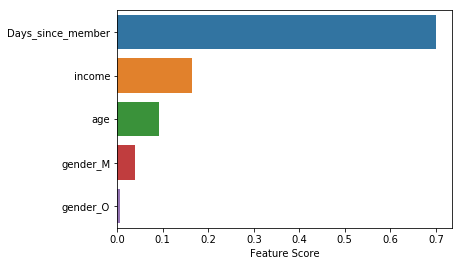

In [53]:
# Feature importance of CV model for plotting
features = pd.Series(clf.best_estimator_.steps[0][1].feature_importances_,index=df_offer_model.iloc[:, :5].columns).sort_values(ascending=False)

# Creating a bar plot
sns.barplot(x=features, y=features.index)

# Add labels to your graph
plt.xlabel('Feature Score')
plt.legend()
plt.show()

# Results

### <a class="anchor" id="Model Evaluation and Validation">Part I : Model Evaluation and Validation</a>

* The results obtained in the initial and adjusted model are satisfactory (greater than 60%). In most of the refined models, F-scores are greater than 70%, which shows its high predictive capacity in relation to the initial model. Additionally, the optimized parameters of GridSearchCV found are explaining in a better way the behavior of the costumers.

* Regarding the Features Scores, we identified that the most important variable is “Days since member”, which shows the loyalty of the oldest clients in consuming products. In the other hand, income and age are variables that affect the result but not as much as “Days since member”. The gender variable seems to have no impact in the results.

### <a class="anchor" id="Justification">Part II : Justification</a>

* The results are consistent with expectations. Those clients who have been around the longest time as members, are the ones with a greater propensity to consume offers. In turn, the variable of income and age are not transcendental in the results given that the cost / income ratio is low and it is common to see coffee consumption in all age ranges.

* The reason why the parameters can change between offers is because depending on whether they are discount / BOGO / Informational, they can have different effects on the population which can be collected through more branches, depth and number of estimators for the trees.

# Conclusion

### <a class="anchor" id="Reflection">Part I : Reflection</a>

To recapitulate what I've done so far:

* Upload the starbucks information of consumer demographics and transactions during a period of time, with the offers sent clients.
* Explored and visualize the Data
* Apply a series of preprocessing steps for cleaning and getting finally a user-matrix for the ML model.
* Execute a Classification model with random forest for obtaining the users influenced by the offers based on their demographics.
* Refine our model doing GridSearchCV for finding the best parameters.

It's interesting to note that the preprocessing part was very time-consuming and there are several ways to approach the problem and finding the best model. I wrote code several times trying to aim the more efficient way to execute the program, and that´s one of the main reasons software engineering skills are vital for a Data Science Position.



### <a class="anchor" id="Improvement">Part II : Improvement</a>


* As a key part of the analysis, it is not only necessary to rely on whether or not the user will respond to the offer, but rather because of their consumption habits. In some cases, they may not need this type of offer since they consume the product with a high frequency. For this, you could use the information source built per transaction and compare the total hourly consumption in USD vs. the consumption during the period of validity of the promotion.

* An important assumption was that all submitted offers had to be completed in order to be considered the client as influenced by the offer. This could be adjusted to recognize that in some cases 50%, 30% of the offers can be considered as valid.

* It is important to incorporate some characteristics of the offers type in the model such as: channel, difficulty and rewards. These factors may be important for improving our results.

* Choosing other types of ML models such as neural networks or some other classification models are another possibility for improvement. Also we could define a greater variety of hyperparameters, however this can be costly in terms of time and computational effort.

# References
[1] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

[2] https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html